Check running TensorFlow version

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

# Dogs vs. Cats

This is a continuation to the previous notebook. Here will try feature-extraction with a pretrained VGG16 model.

In [2]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

In [3]:
batch_size = 16

## Prepare the dataset

I manually downloaded the dataset from this [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats), unzipped it and here I will prepare for model training

In [4]:
data_path = Path("../data")
data_path.ls()

[PosixPath('../data/preprocessed'), PosixPath('../data/raw')]

In [5]:
dogs_vs_cats_dir_name = "dogs-vs-cats"
raw_dir_name = "raw"
preprocessed_dir_name = "preprocessed"

train_dir_name = "train"
valid_dir_name = "valid"
test_dir_name = "test"

dogs_dir_name = "dogs"
cats_dir_name = "cats"

raw_data_path = data_path/raw_dir_name/dogs_vs_cats_dir_name
preprocessed_data_path = data_path/preprocessed_dir_name/dogs_vs_cats_dir_name

dogs_train_data_path = preprocessed_data_path/train_dir_name/dogs_dir_name
cats_train_data_path = preprocessed_data_path/train_dir_name/cats_dir_name

dogs_valid_data_path = preprocessed_data_path/valid_dir_name/dogs_dir_name
cats_valid_data_path = preprocessed_data_path/valid_dir_name/cats_dir_name

dogs_test_data_path = preprocessed_data_path/test_dir_name/dogs_dir_name
cats_test_data_path = preprocessed_data_path/test_dir_name/cats_dir_name

## Build data generators

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    str(preprocessed_data_path/train_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = train_datagen.flow_from_directory(
    str(preprocessed_data_path/valid_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    str(preprocessed_data_path/test_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Check datagen outputs

## Train a basic ConvNet model

In [7]:
input_shape = train_generator[0][0].shape[1:]
input_shape

(150, 150, 3)

In [8]:
model = Sequential()

conv_base = VGG16(input_shape=input_shape,
                  include_top=False,
                  weights='imagenet')
conv_base.trainable = False
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Check progress in TensorBoard by running `tensorboard --logdir=logs/dogs_vs_cats_v3` in terminal

In [9]:
# Try removing the old logs first
!rm -r ../logs/dogs_vs_cats_v3

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/dogs_vs_cats_v3')
]

In [10]:
model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
steps_per_epoch = len(train_generator)
validation_steps = len(valid_generator)

steps_per_epoch, validation_steps

(125, 63)

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    callbacks=callbacks,
    validation_data=valid_generator,
    validation_steps=validation_steps
)
history.history.keys()

W0821 03:29:32.845804 140435048908544 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
  1/125 [..............................] - ETA: 8:55 - loss: 0.8169 - accuracy: 0.4375

W0821 03:29:37.085351 140435048908544 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.285689). Check your callbacks.


125/125 [==============================] - 24s 189ms/step - loss: 0.6969 - accuracy: 0.5775 - val_loss: 0.5622 - val_accuracy: 0.7300
Epoch 2/30
125/125 [==============================] - 18s 145ms/step - loss: 0.5580 - accuracy: 0.7095 - val_loss: 0.4955 - val_accuracy: 0.7820
Epoch 3/30
125/125 [==============================] - 19s 148ms/step - loss: 0.5072 - accuracy: 0.7530 - val_loss: 0.4619 - val_accuracy: 0.7970
Epoch 4/30
125/125 [==============================] - 18s 147ms/step - loss: 0.4640 - accuracy: 0.7815 - val_loss: 0.4505 - val_accuracy: 0.7880
Epoch 5/30
125/125 [==============================] - 19s 149ms/step - loss: 0.4601 - accuracy: 0.7880 - val_loss: 0.4149 - val_accuracy: 0.8160
Epoch 6/30
125/125 [==============================] - 18s 148ms/step - loss: 0.4438 - accuracy: 0.7880 - val_loss: 0.4194 - val_accuracy: 0.8050
Epoch 7/30
125/125 [==============================] - 18s 147ms/step - loss: 0.4446 - accuracy: 0.7870 - val_loss: 0.4221 - val_accuracy: 0.8

dict_keys(['accuracy', 'val_accuracy', 'val_loss', 'loss'])

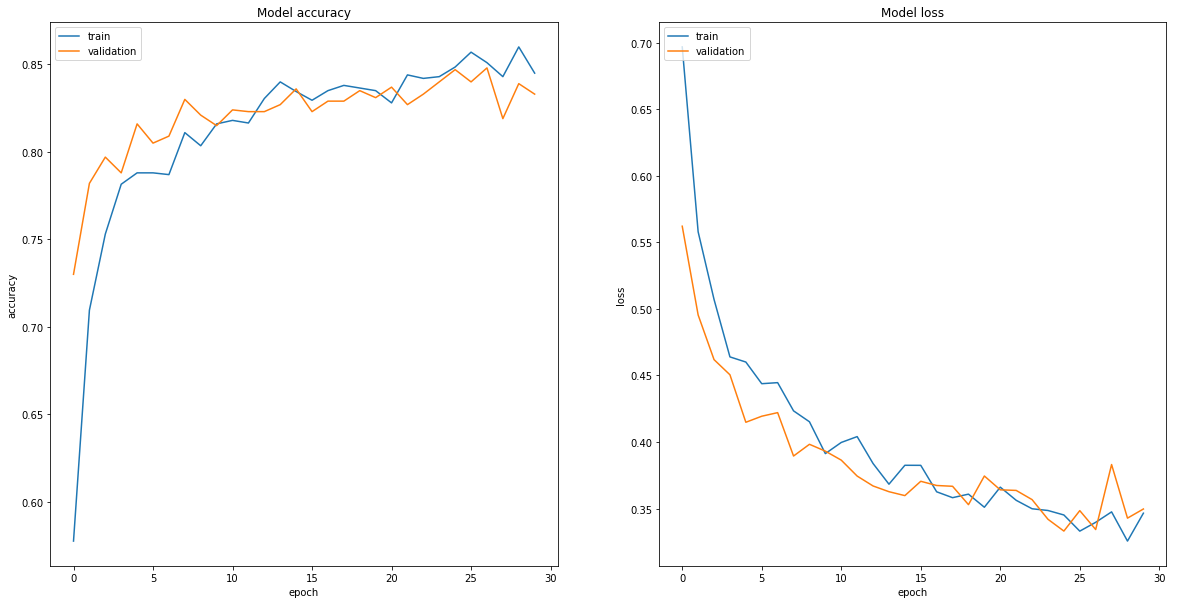

In [13]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Save the model

In [8]:
weights_path = Path("../weights")
weights_path.mkdir(parents=True, exist_ok=True)

In [15]:
model.save(str(weights_path/"dogs_vs_cats_v3.h5"))

## Evaluate

Load the saved model

In [9]:
model = keras.models.load_model(str(weights_path/"dogs_vs_cats_v3.h5"))

W0822 09:30:41.087193 4569847232 deprecation.py:323] From /Users/mostafagazar/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 0
Non-trainable params: 16,812,353
_________________________________________________________________


In [11]:
steps = len(test_generator)

loss, accuracy = model.evaluate_generator(
    test_generator,
    steps=steps
)
loss, accuracy

(0.26432626883661936, 0.898)